# **1- Packages**

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from keras.layers import Conv1D, Dense, Input, MaxPooling1D, Dropout, Flatten
from keras.models import Sequential

from colorama import Fore, Back, Style
from yellowbrick.classifier import ROCAUC

sns.set_style('dark')
warnings.filterwarnings('ignore')

# **2- Data Preparation & EDA**

In [2]:
df = pd.read_csv('input/cirrhosis.csv')
df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [3]:
df = df.drop('ID', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Status         418 non-null    object 
 2   Drug           312 non-null    object 
 3   Age            418 non-null    int64  
 4   Sex            418 non-null    object 
 5   Ascites        312 non-null    object 
 6   Hepatomegaly   312 non-null    object 
 7   Spiders        312 non-null    object 
 8   Edema          418 non-null    object 
 9   Bilirubin      418 non-null    float64
 10  Cholesterol    284 non-null    float64
 11  Albumin        418 non-null    float64
 12  Copper         310 non-null    float64
 13  Alk_Phos       312 non-null    float64
 14  SGOT           312 non-null    float64
 15  Tryglicerides  282 non-null    float64
 16  Platelets      407 non-null    float64
 17  Prothrombin    416 non-null    float64
 18  Stage     

In [4]:
df.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
mean,1917.782297,18533.351675,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,1104.672992,3815.845055,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,41.000000,9598.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,1092.750000,15644.500000,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,1730.000000,18628.000000,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,2613.500000,21272.500000,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000
max,4795.000000,28650.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,721.000000,18.000000,4.000000


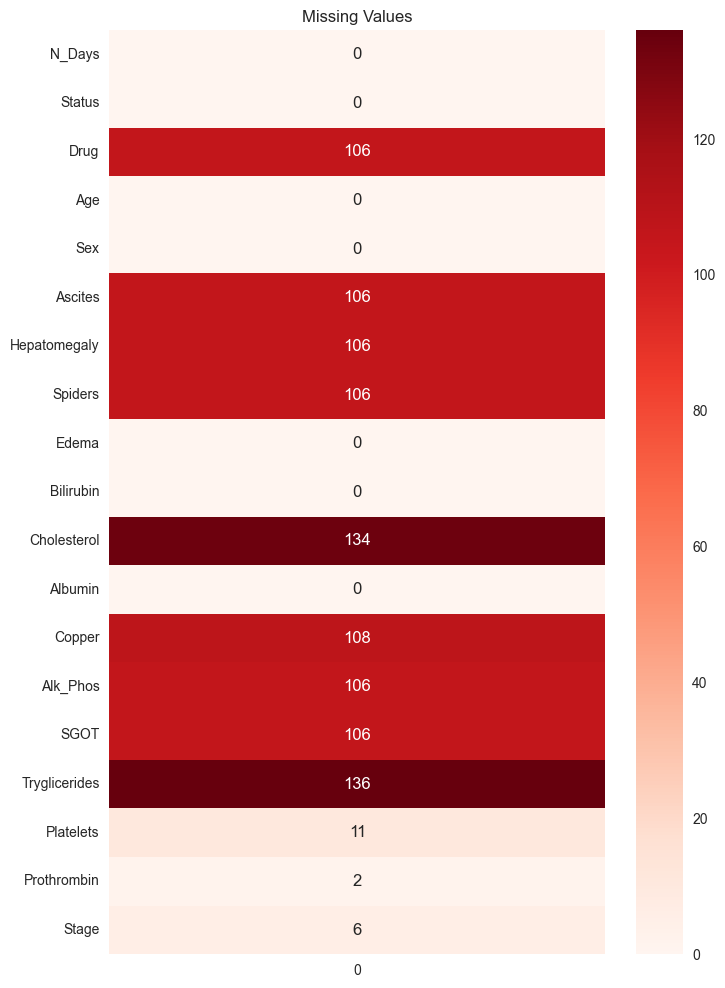

In [5]:
plt.figure(figsize=(8, 12))
plt.title('Missing Values')
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='Reds')
plt.show()

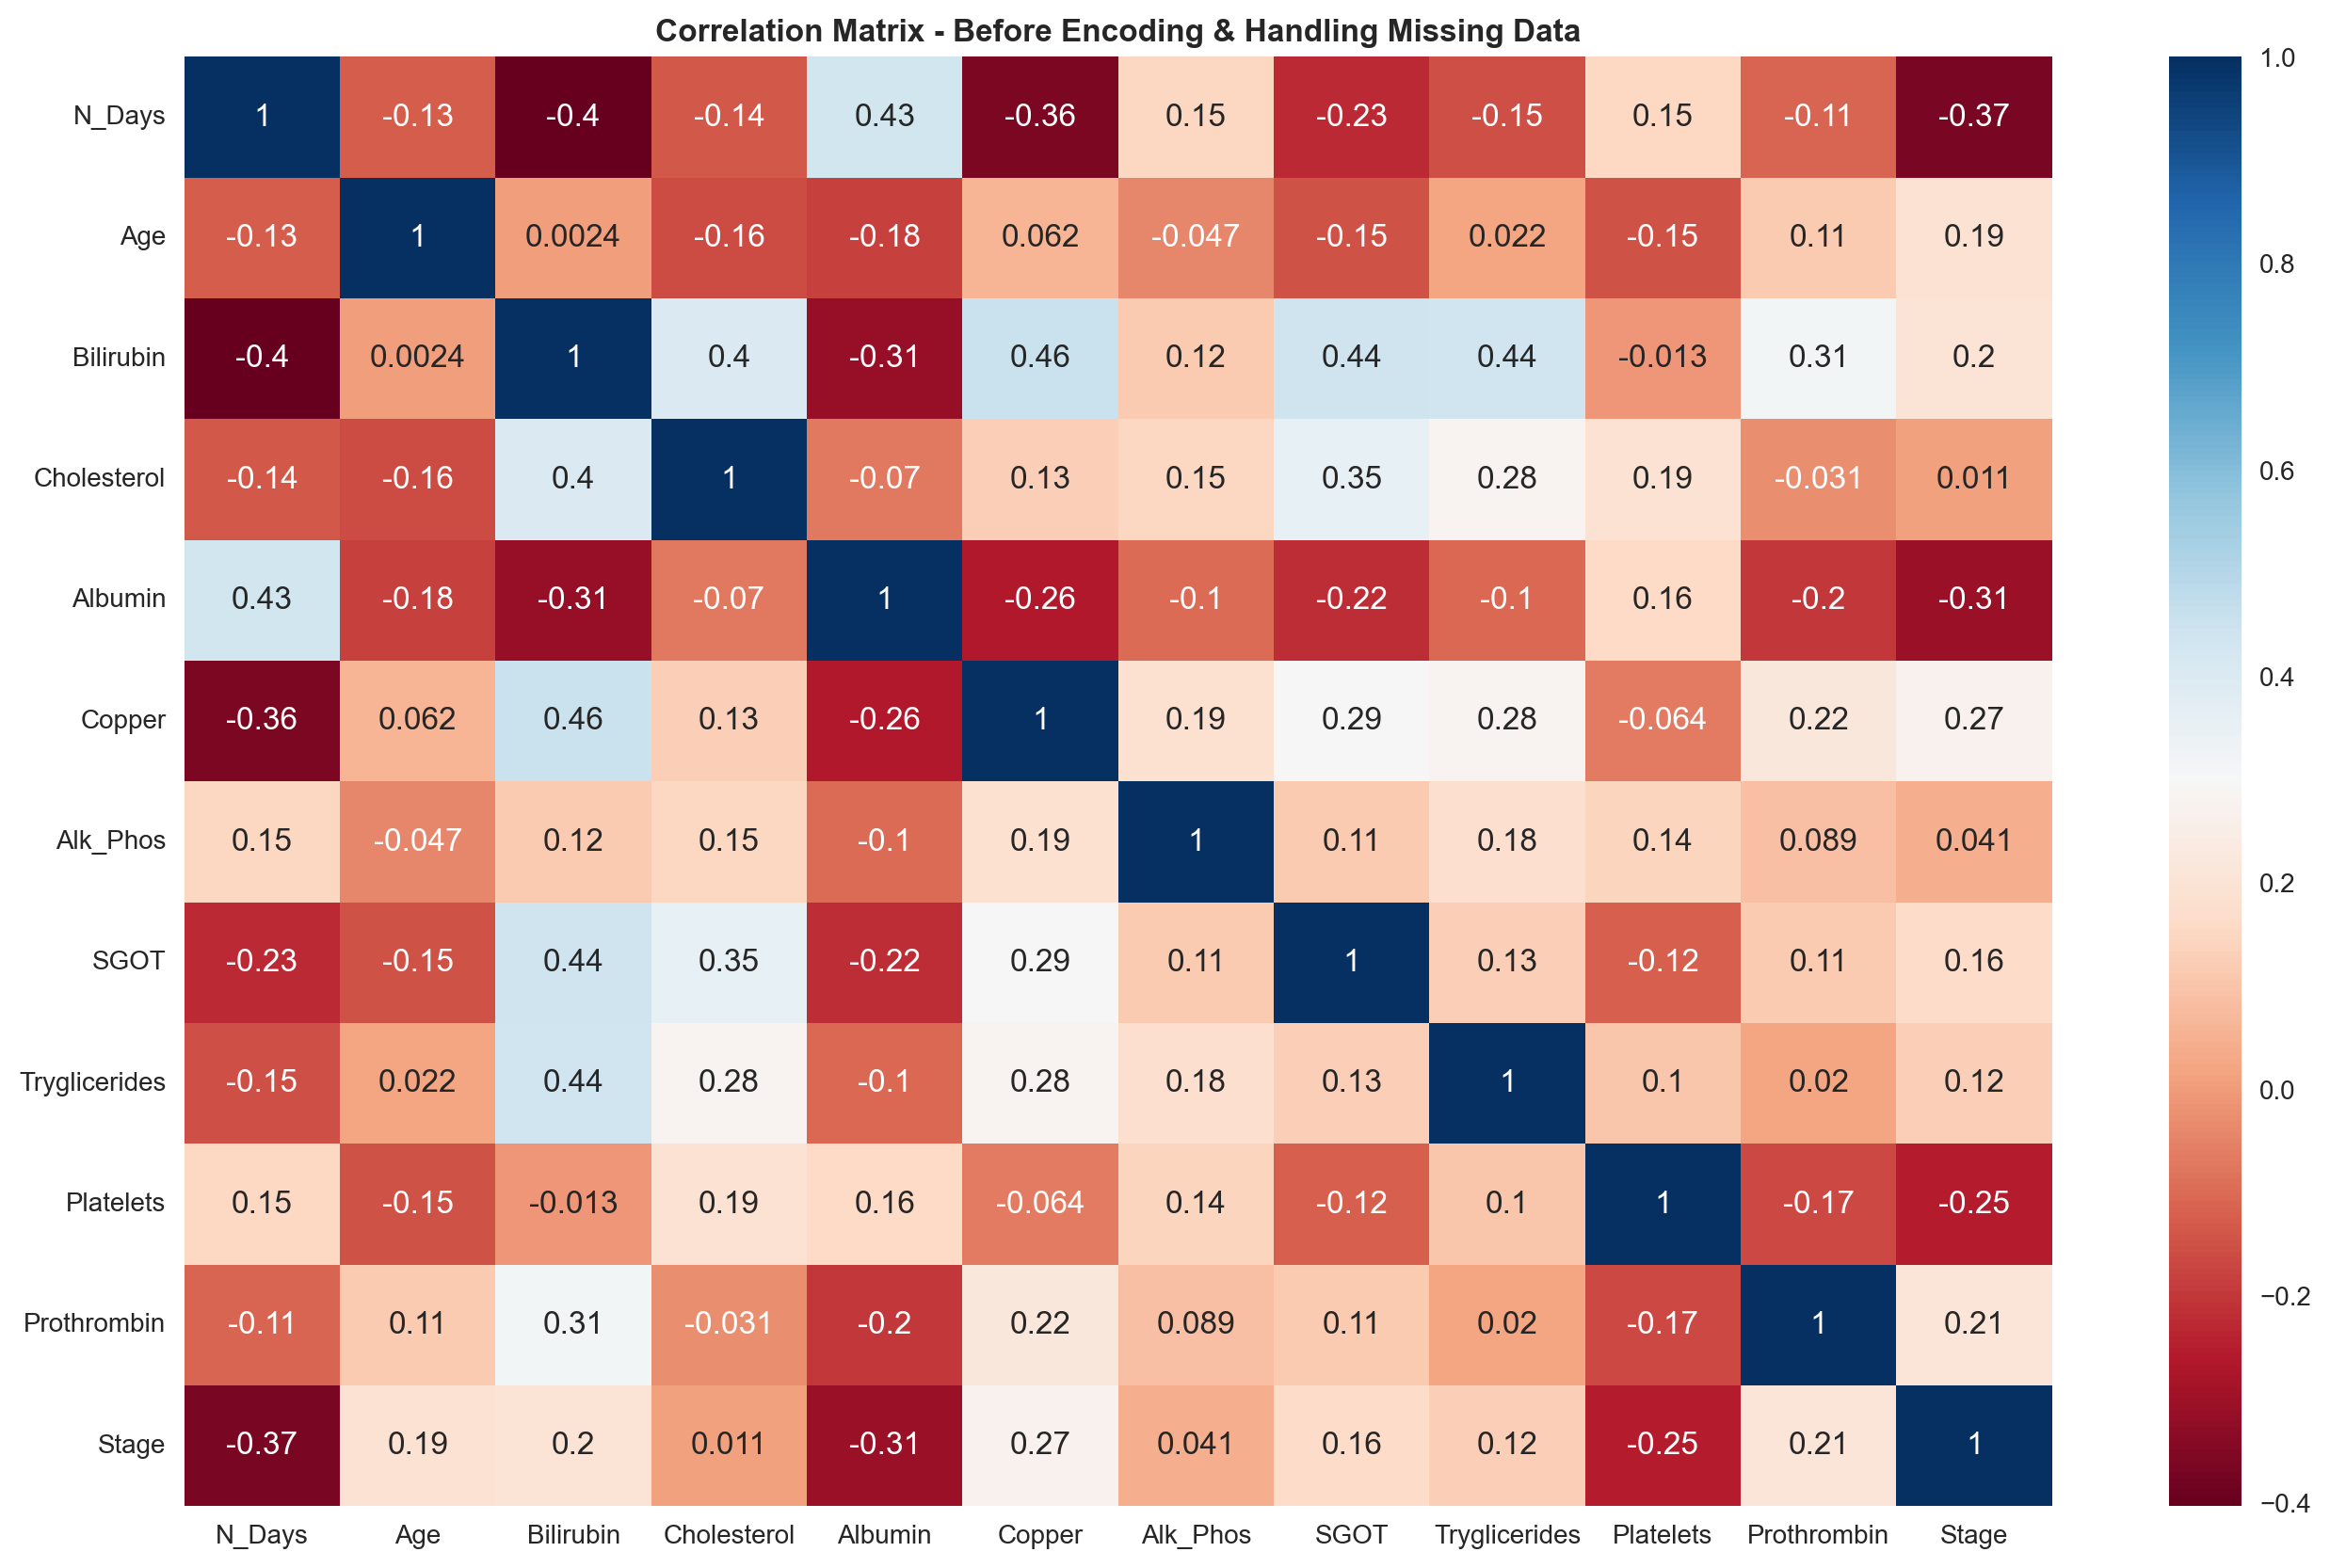

In [6]:
plt.figure(figsize = (16,10), dpi=200)
ax = plt.axes()
sns.heatmap(df.corr(), annot = True, cmap='RdBu', ax=ax)
ax.set_title('Correlation Matrix - Before Encoding & Handling Missing Data', weight='bold')
plt.show()

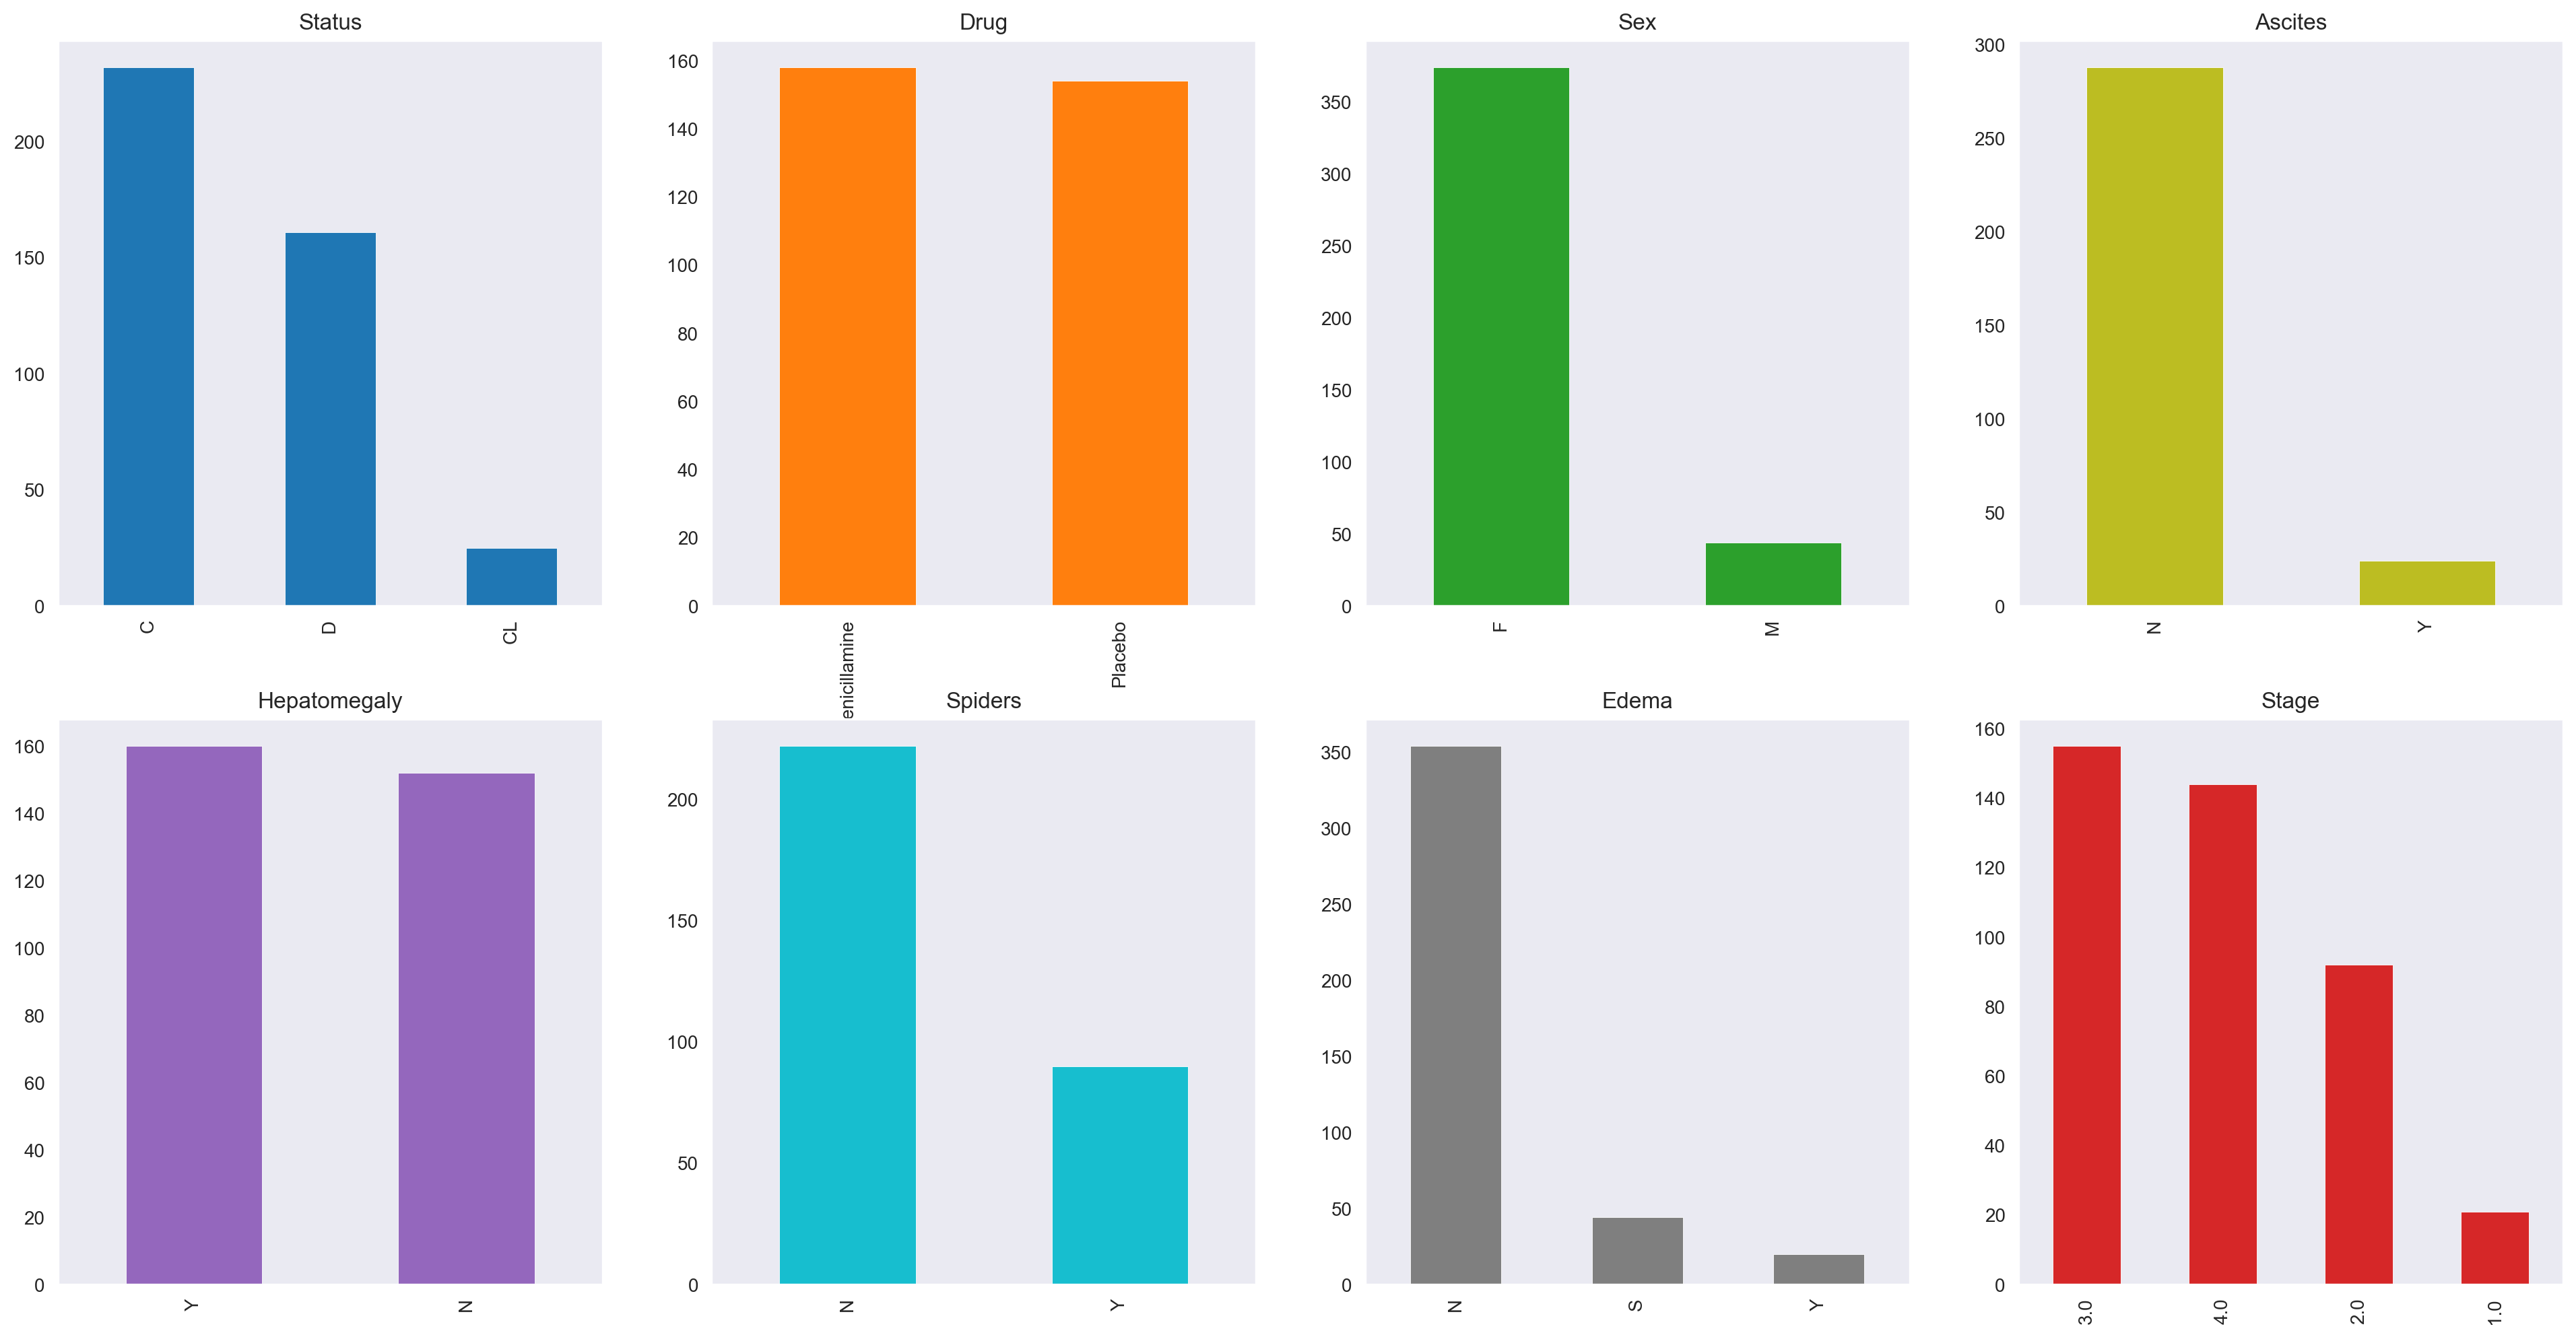

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, dpi=200, figsize=(24, 12))

df.Status.value_counts().plot(kind='bar', color='tab:blue', title='Status', ax=axes[0,0])
df.Drug.value_counts().plot(kind='bar', color='tab:orange', title='Drug', ax=axes[0,1])
df.Sex.value_counts().plot(kind='bar', color='tab:green', title='Sex', ax=axes[0,2])
df.Ascites.value_counts().plot(kind='bar', color='tab:olive', title='Ascites', ax=axes[0,3])

df.Hepatomegaly.value_counts().plot(kind='bar', color='tab:purple', title='Hepatomegaly', ax=axes[1,0])
df.Spiders.value_counts().plot(kind='bar', color='tab:cyan', title='Spiders', ax=axes[1,1])
df.Edema.value_counts().plot(kind='bar', color='tab:grey', title='Edema', ax=axes[1,2])
df.Stage.value_counts().plot(kind='bar', color='tab:red', title='Stage', ax=axes[1,3]);

In [8]:
""" Handling Missing Values """

# I'm going to drop the 6 rows with missing 'Stage'
df = df[df['Stage'].notna()]

# Numerical --> Median
numerical_columns = df.select_dtypes(include=(['int64', 'float64'])).columns

for c in numerical_columns:
    df[c].fillna(df[c].median(), inplace=True)
    
# Categorical --> Most Frequent
categorical_columns = df.select_dtypes(include=('object')).columns

for c in categorical_columns:
    df[c].fillna(df[c].mode().values[0], inplace=True)

    
df.Stage = df.Stage.astype(int)

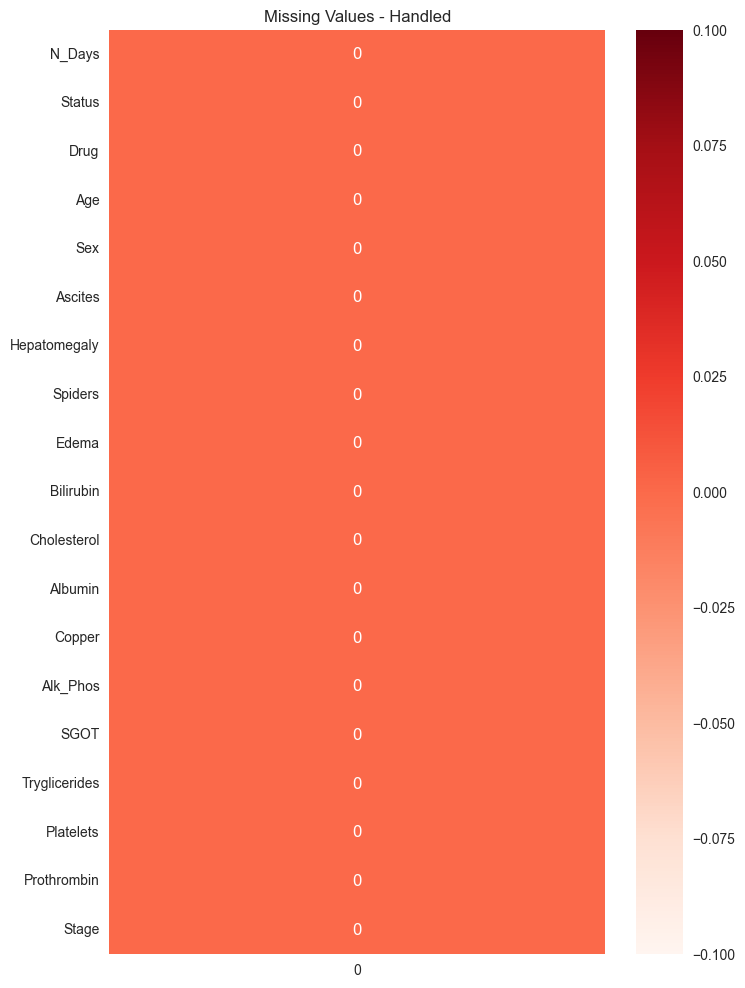

In [9]:
plt.figure(figsize=(8, 12))
plt.title('Missing Values - Handled')
ax = sns.heatmap(df.isna().sum().to_frame(), annot=True, fmt='d', cmap='Reds')
plt.show()

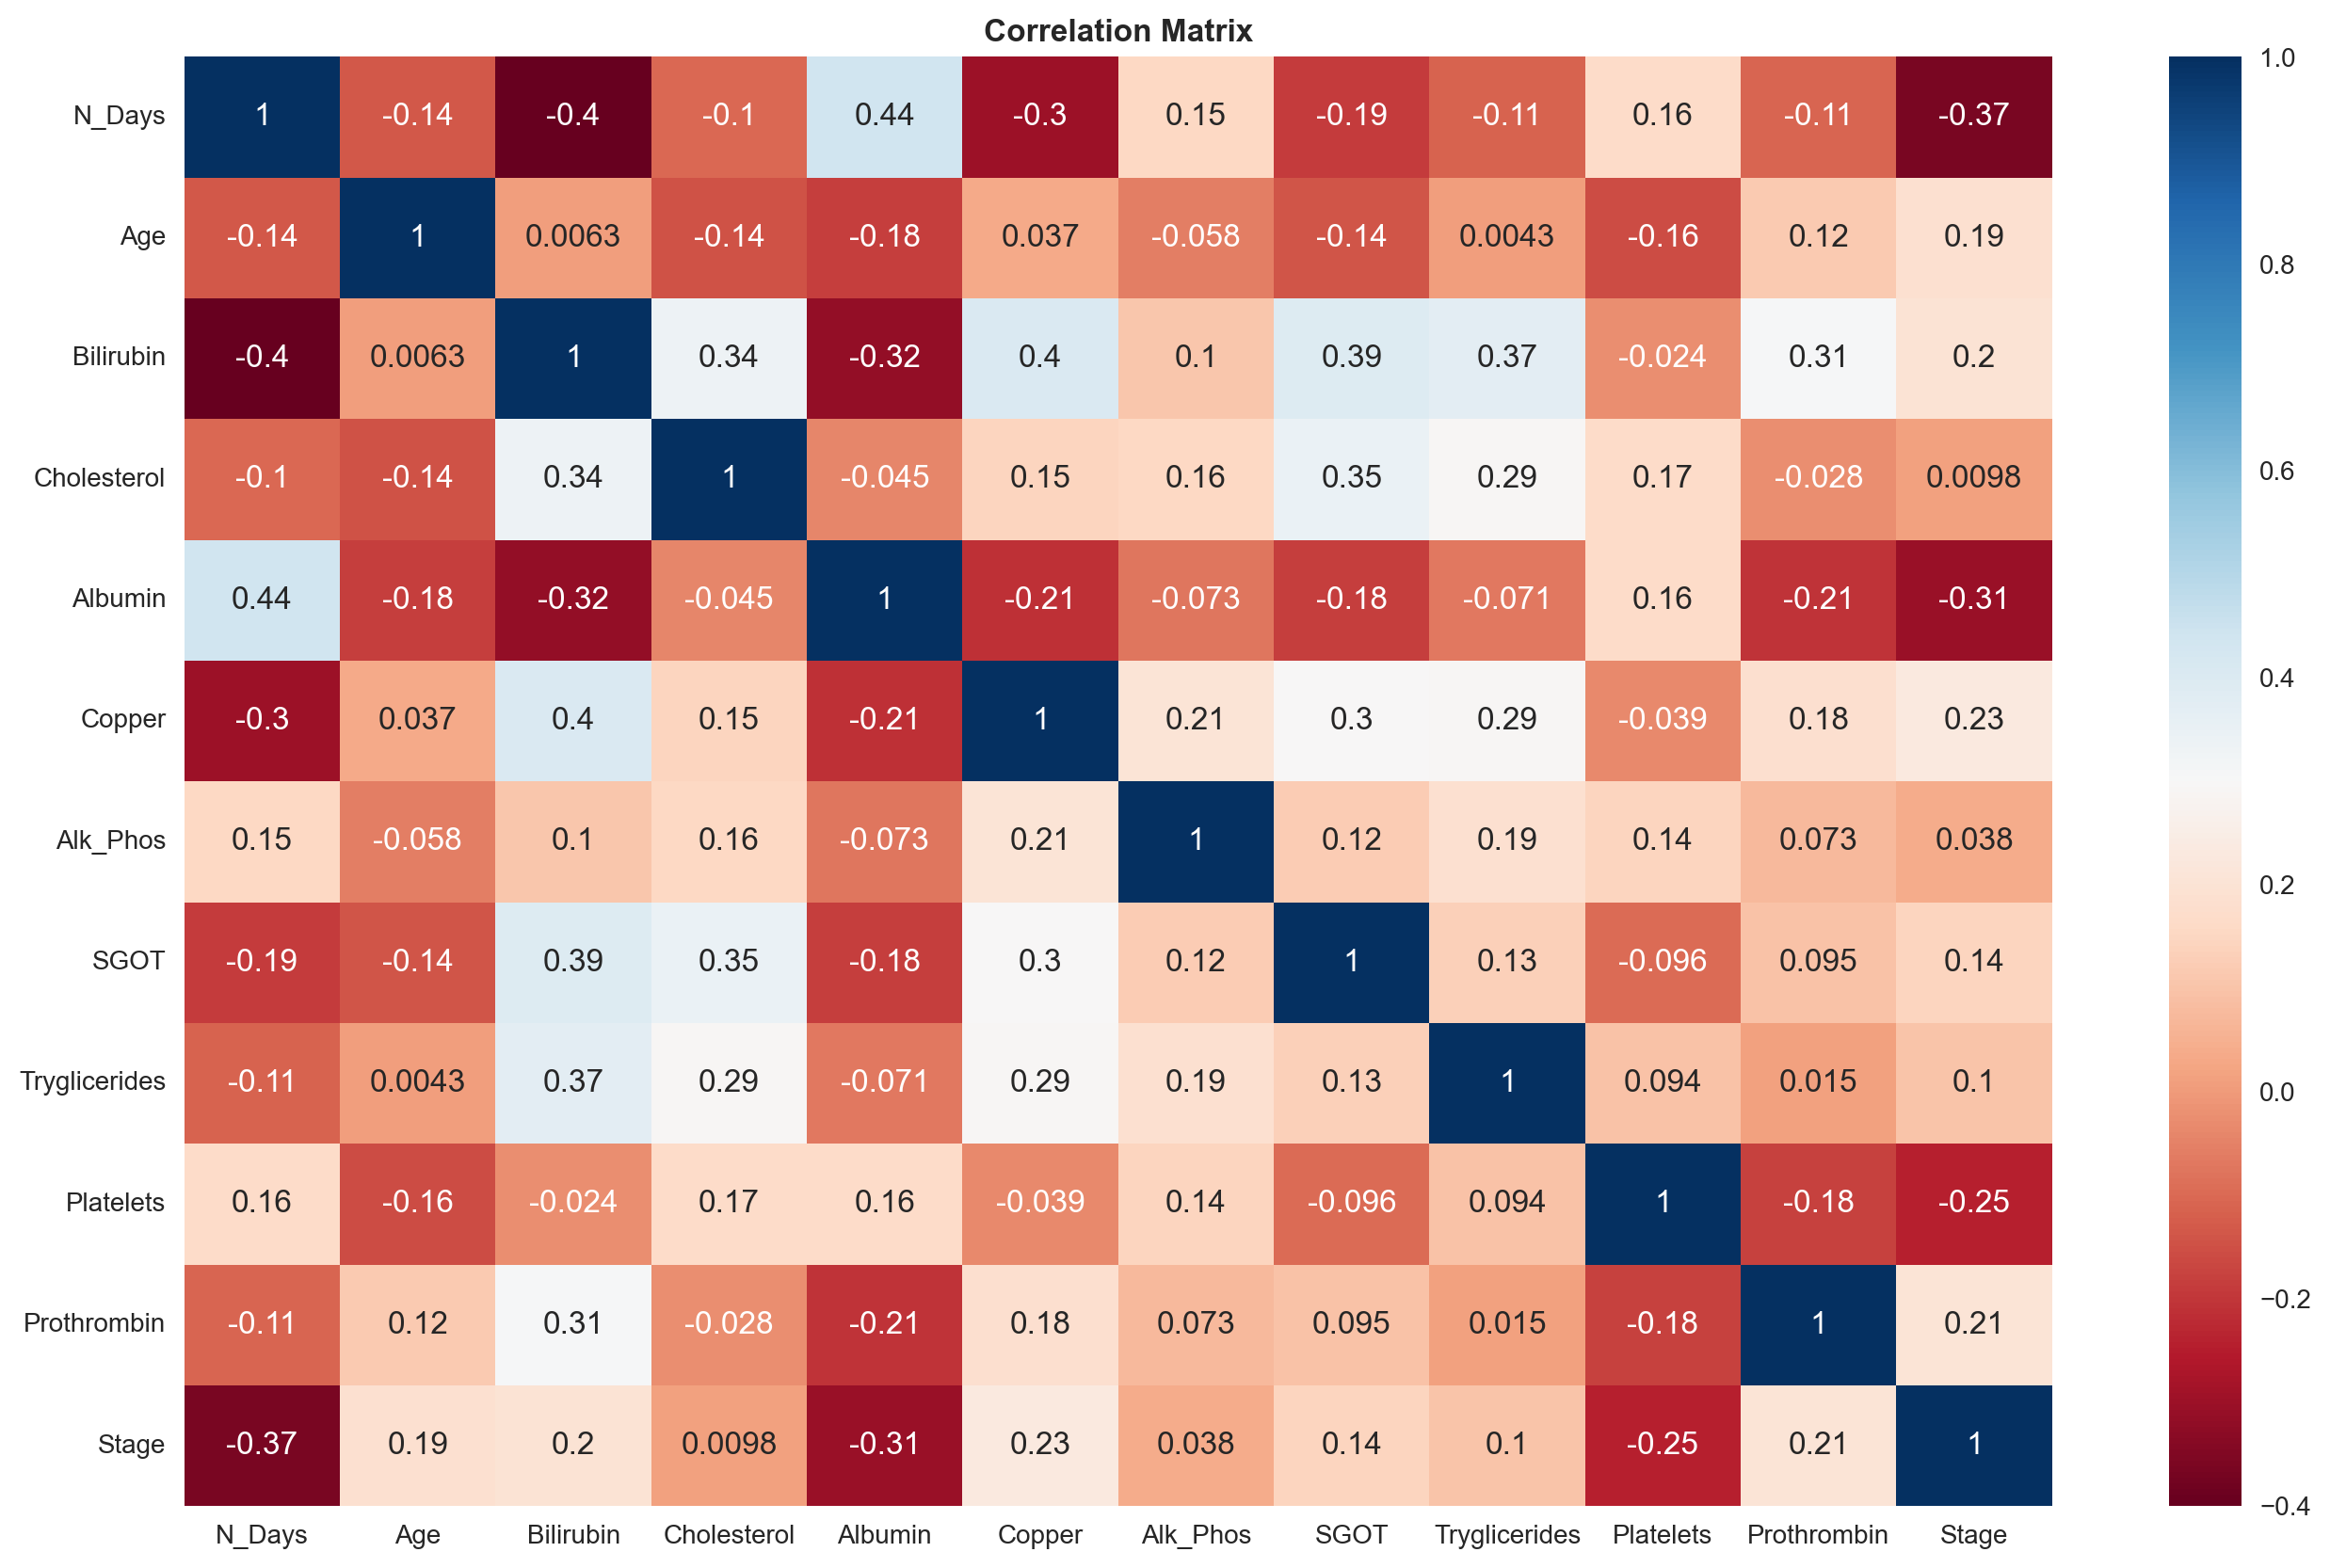

In [10]:
plt.figure(figsize = (16,10), dpi=200)
ax = plt.axes()
sns.heatmap(df.corr(), annot = True, cmap='RdBu', ax=ax)
ax.set_title('Correlation Matrix', weight='bold')
plt.show()

In [11]:
# Dummy Variables
df['Sex'] = df['Sex'].replace({'M':0, 'F':1})
df['Ascites'] = df['Ascites'].replace({'N':0, 'Y':1})
df['Drug'] = df['Drug'].replace({'D-penicillamine':0, 'Placebo':1})
df['Hepatomegaly'] = df['Hepatomegaly'].replace({'N':0, 'Y':1})
df['Spiders'] = df['Spiders'].replace({'N':0, 'Y':1})
df['Edema'] = df['Edema'].replace({'N':0, 'Y':1, 'S':-1})
df['Status'] = df['Status'].replace({'C':0, 'CL':1, 'D':-1})

In [12]:
X = df.drop(['Status', 'N_Days', 'Stage'], axis=1)
y = df.pop('Stage')

In [13]:
# Upsamlping
sm = SMOTE(k_neighbors = 3)
X, y = sm.fit_resample(X, y)

In [14]:
# Scaling Data
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 23)

# **3- Modeling**

In [16]:
# Performance Comparison Visualization

def score_vis(score):
    
    names = ['SVM', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'AdaBoost', 'KNN']

    plt.rcParams['figure.figsize']=20,8
    ax = sns.barplot(x=names, y=score, palette = "plasma", saturation =2.0)
    plt.xlabel('Model', fontsize = 20 )
    plt.ylabel('Accuracy(%)', fontsize = 20)
    plt.title('Model Comparison - Test set', fontsize = 20)
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
    plt.yticks(fontsize = 12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
    plt.show()

In [17]:
def trainer(X_train, y_train, X_test, y_test):
    
    models= [[' SVM ',SVC()],
             [' Decision Tree ', DecisionTreeClassifier()],
             [' Random Forest ', RandomForestClassifier()],
             [' Logistic Regression ', LogisticRegression(max_iter=200)],
             [' AdaBoost ', AdaBoostClassifier()],
             [' KNN ', KNeighborsClassifier()]]

    scores = []
    
    for model_name, model in models:
        model = model
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        cm_model = confusion_matrix(y_test, pred)
        scores.append(accuracy_score(y_test, model.predict(X_test)))
        

        print(Back.YELLOW + Fore.BLACK + Style.BRIGHT + model_name)
        print(Back.RESET)
        print(cm_model)
        print('\n' + Fore.BLUE + 'Training Acc.  : ' + Fore.GREEN + str(round(accuracy_score(y_train, model.predict(X_train)) * 100, 2)) + '%' )
        print(Fore.BLUE + 'Validation Acc.: ' + Fore.GREEN + str(round(accuracy_score(y_test, model.predict(X_test)) * 100, 2)) + '%' )
        print(Fore.CYAN + classification_report(y_test, pred)) 
        
        visualizer = ROCAUC(model)
        visualizer.fit(X_train, y_train)
        visualizer.score(X_test, y_test)
        visualizer.show()   

        print('\n' + Fore.BLACK + Back.WHITE + '⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜\n')
    
        
    return scores

 SVM 

[[35  3  0  0]
 [ 7  9 10  7]
 [ 2  5 12  5]
 [ 0  2  6 21]]

Training Acc.  : 77.02%
Validation Acc.: 62.1%
              precision    recall  f1-score   support

           1       0.80      0.92      0.85        38
           2       0.47      0.27      0.35        33
           3       0.43      0.50      0.46        24
           4       0.64      0.72      0.68        29

    accuracy                           0.62       124
   macro avg       0.58      0.60      0.58       124
weighted avg       0.60      0.62      0.60       124



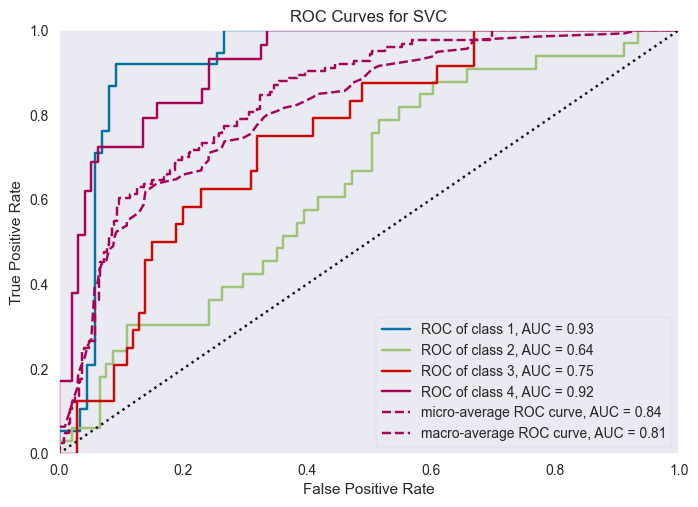


⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

 Decision Tree 

[[35  3  0  0]
 [ 3 18  8  4]
 [ 1  8 11  4]
 [ 1  4  7 17]]

Training Acc.  : 100.0%
Validation Acc.: 65.32%
              precision    recall  f1-score   support

           1       0.88      0.92      0.90        38
           2       0.55      0.55      0.55        33
           3       0.42      0.46      0.44        24
           4       0.68      0.59      0.63        29

    accuracy                           0.65       124
   macro avg       0.63      0.63      0.63       124
weighted avg       0.65      0.65      0.65       124



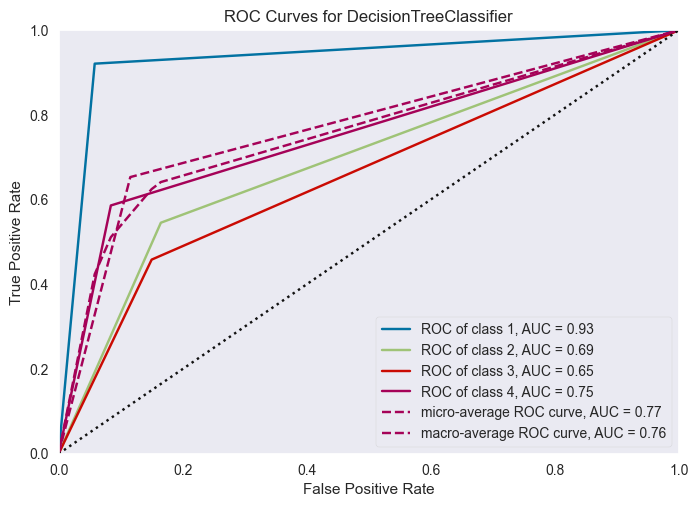


⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

 Random Forest 

[[35  3  0  0]
 [ 3 16 10  4]
 [ 2  4 14  4]
 [ 0  2  6 21]]

Training Acc.  : 100.0%
Validation Acc.: 69.35%
              precision    recall  f1-score   support

           1       0.88      0.92      0.90        38
           2       0.64      0.48      0.55        33
           3       0.47      0.58      0.52        24
           4       0.72      0.72      0.72        29

    accuracy                           0.69       124
   macro avg       0.68      0.68      0.67       124
weighted avg       0.70      0.69      0.69       124



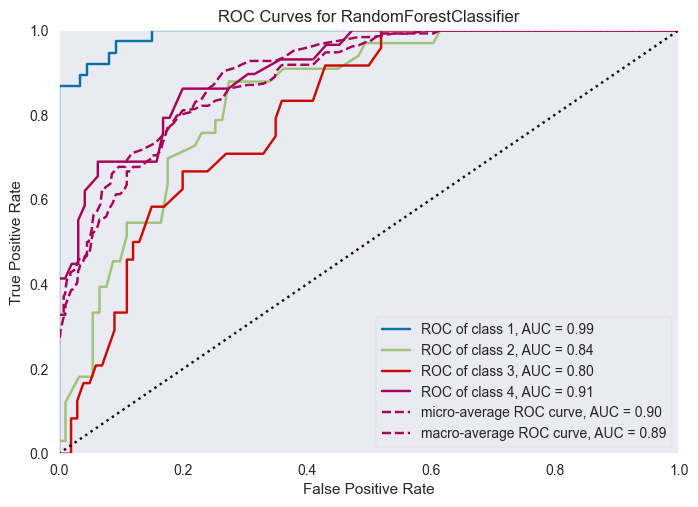


⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

 Logistic Regression 

[[30  8  0  0]
 [ 9  8 12  4]
 [ 3  6  8  7]
 [ 0  1  8 20]]

Training Acc.  : 58.27%
Validation Acc.: 53.23%
              precision    recall  f1-score   support

           1       0.71      0.79      0.75        38
           2       0.35      0.24      0.29        33
           3       0.29      0.33      0.31        24
           4       0.65      0.69      0.67        29

    accuracy                           0.53       124
   macro avg       0.50      0.51      0.50       124
weighted avg       0.52      0.53      0.52       124



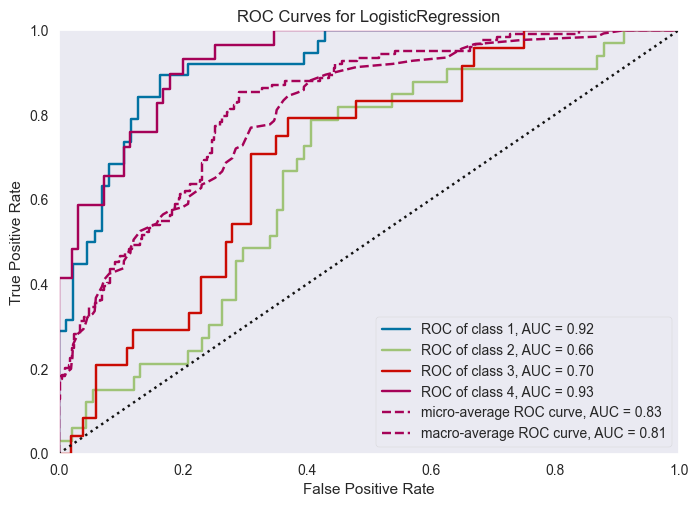


⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

 AdaBoost 

[[25  9  4  0]
 [ 6 13  6  8]
 [ 3  7  6  8]
 [ 0  4  7 18]]

Training Acc.  : 64.11%
Validation Acc.: 50.0%
              precision    recall  f1-score   support

           1       0.74      0.66      0.69        38
           2       0.39      0.39      0.39        33
           3       0.26      0.25      0.26        24
           4       0.53      0.62      0.57        29

    accuracy                           0.50       124
   macro avg       0.48      0.48      0.48       124
weighted avg       0.50      0.50      0.50       124



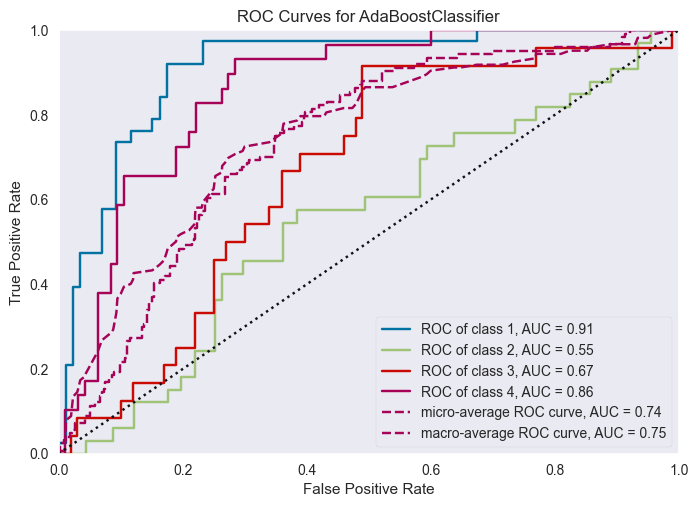


⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜

 KNN 

[[34  4  0  0]
 [10 10 10  3]
 [ 6  5 10  3]
 [ 1  1  8 19]]

Training Acc.  : 71.77%
Validation Acc.: 58.87%
              precision    recall  f1-score   support

           1       0.67      0.89      0.76        38
           2       0.50      0.30      0.38        33
           3       0.36      0.42      0.38        24
           4       0.76      0.66      0.70        29

    accuracy                           0.59       124
   macro avg       0.57      0.57      0.56       124
weighted avg       0.58      0.59      0.57       124



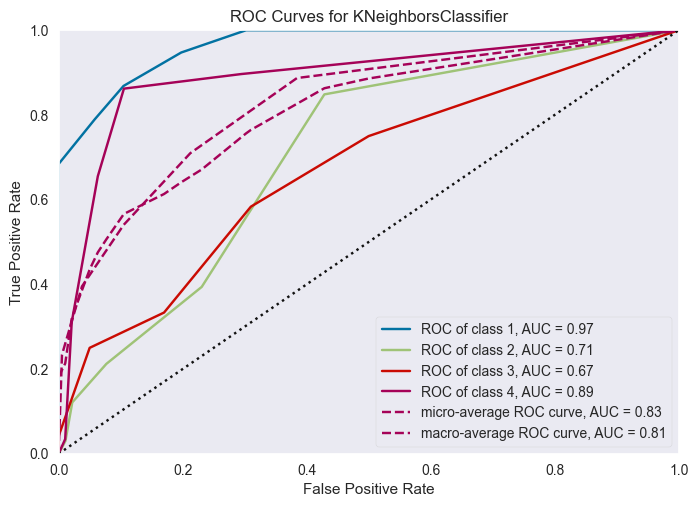


⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜⁜



In [18]:
scores = trainer(X_train, y_train, X_test, y_test)

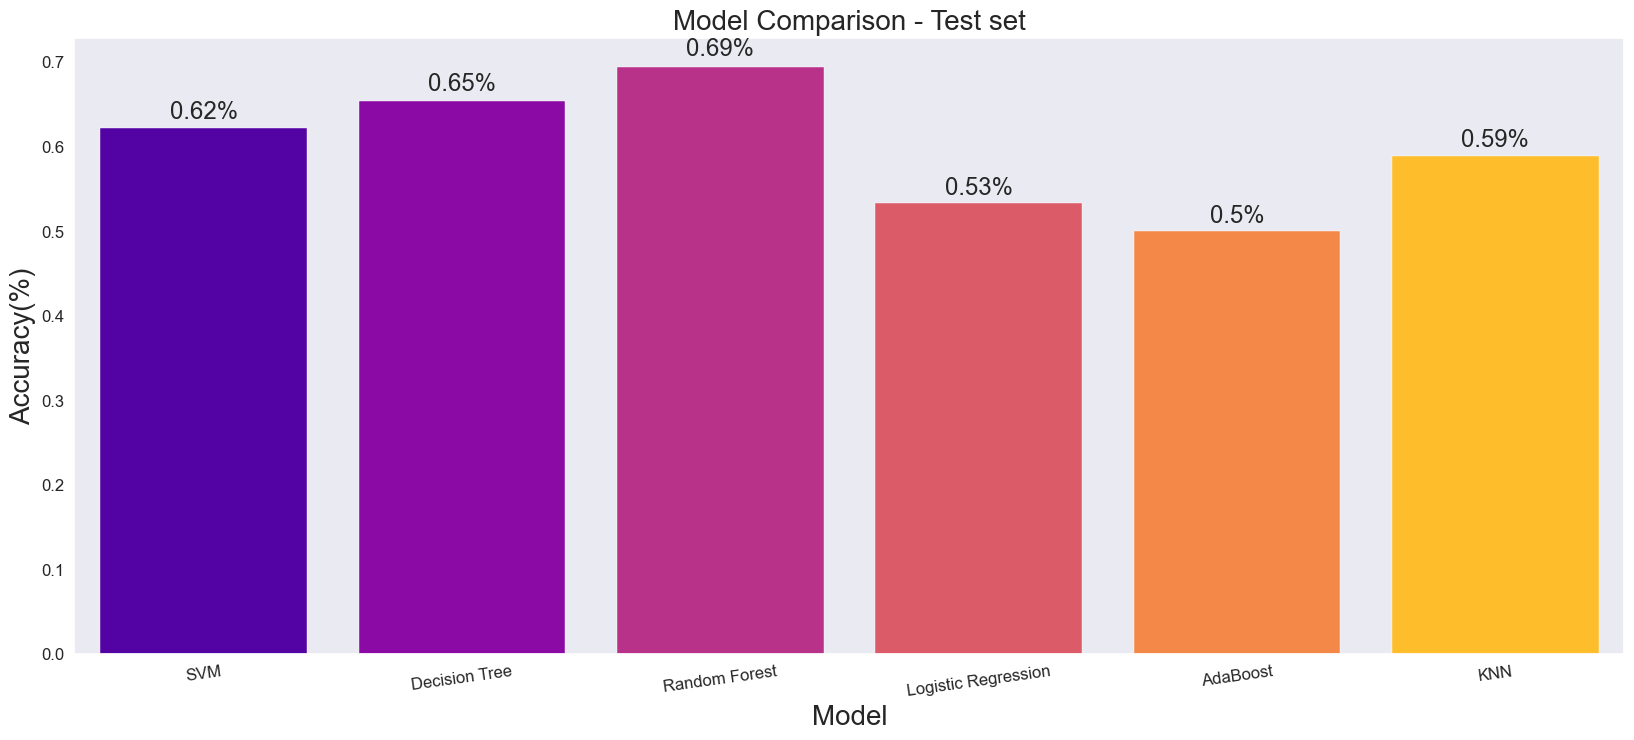

In [19]:
score_vis(scores)

# **4- MLP**

In [20]:
model_mlp = Sequential()

input_shape = (X_train.shape[1],)

model_mlp.add(Dense(32, activation='relu', input_shape=(input_shape)))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(32, activation='relu'))
model_mlp.add(Dense(5, activation='softmax'))

model_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_mlp.build(input_shape=(X_train.shape))
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 4901 (19.14 KB)
Trainable params: 4901 (19.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
h_mlp = model_mlp.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
16/16 [==============================] - 1s 25ms/step - loss: 1.5864 - accuracy: 0.2540 - val_loss: 1.4727 - val_accuracy: 0.3629
Epoch 2/20
16/16 [==============================] - 0s 3ms/step - loss: 1.4147 - accuracy: 0.3891 - val_loss: 1.3413 - val_accuracy: 0.4355
Epoch 3/20
16/16 [==============================] - 0s 3ms/step - loss: 1.2780 - accuracy: 0.5000 - val_loss: 1.2153 - val_accuracy: 0.5000
Epoch 4/20
16/16 [==============================] - 0s 3ms/step - loss: 1.1512 - accuracy: 0.5444 - val_loss: 1.0900 - val_accuracy: 0.5242
Epoch 5/20
16/16 [==============================] - 0s 3ms/step - loss: 1.0481 - accuracy: 0.5786 - val_loss: 1.0070 - val_accuracy: 0.5323
Epoch 6/20
16/16 [==============================] - 0s 3ms/step - loss: 0.9798 - accuracy: 0.6069 - val_loss: 0.9695 - val_accuracy: 0.5484
Epoch 7/20
16/16 [==============================] - 0s 3ms/step - loss: 0.9353 - accuracy: 0.6290 - val_loss: 0.9499 - val_accuracy: 0.5645
Epoch 8/20
16/16 [=

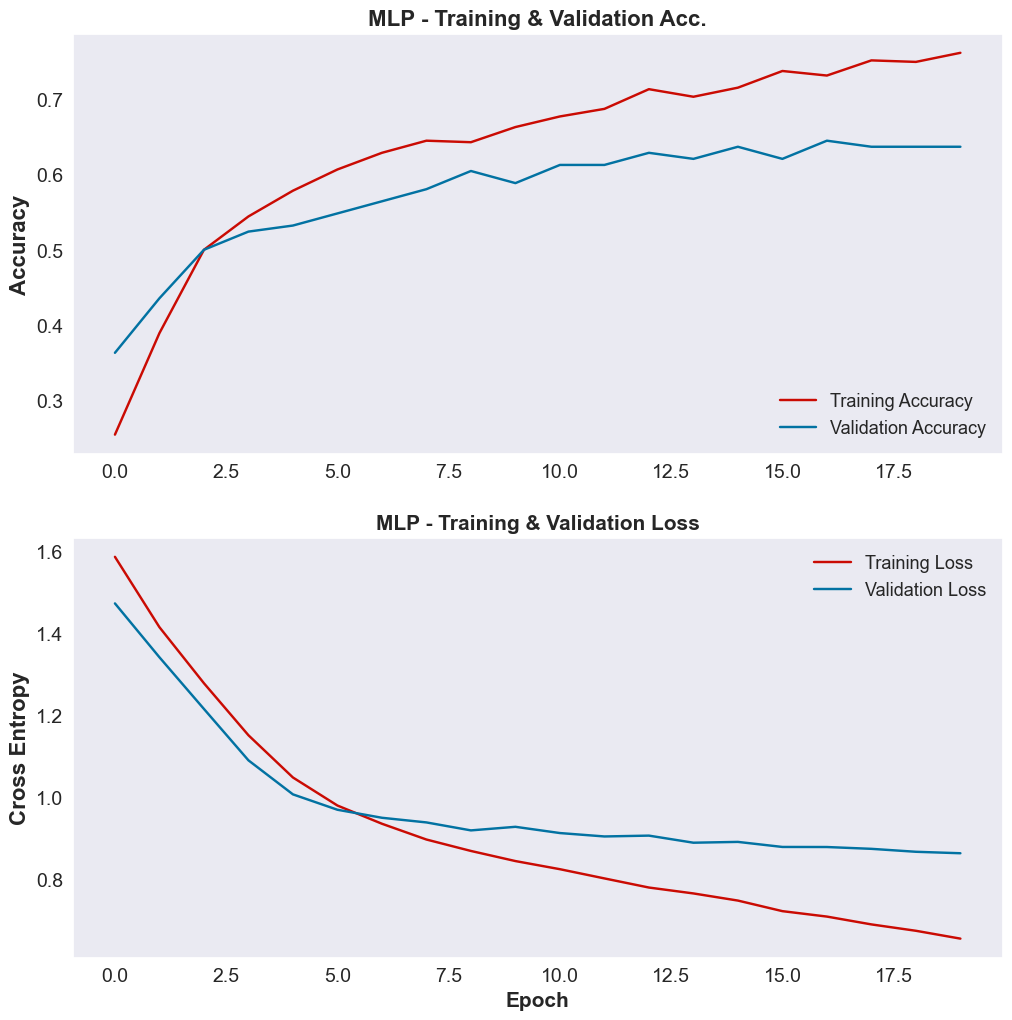

In [22]:
acc = h_mlp.history['accuracy']
val_acc = h_mlp.history['val_accuracy']

loss = h_mlp.history['loss']
val_loss = h_mlp.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('MLP - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('MLP - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [23]:
from sklearn.metrics import classification_report

Y_pred = model_mlp.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(y_test, y_pred))

4/4 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           1       0.85      0.87      0.86        38
           2       0.48      0.42      0.45        33
           3       0.43      0.50      0.46        24
           4       0.71      0.69      0.70        29

    accuracy                           0.64       124
   macro avg       0.62      0.62      0.62       124
weighted avg       0.64      0.64      0.64       124



Normalized confusion matrix


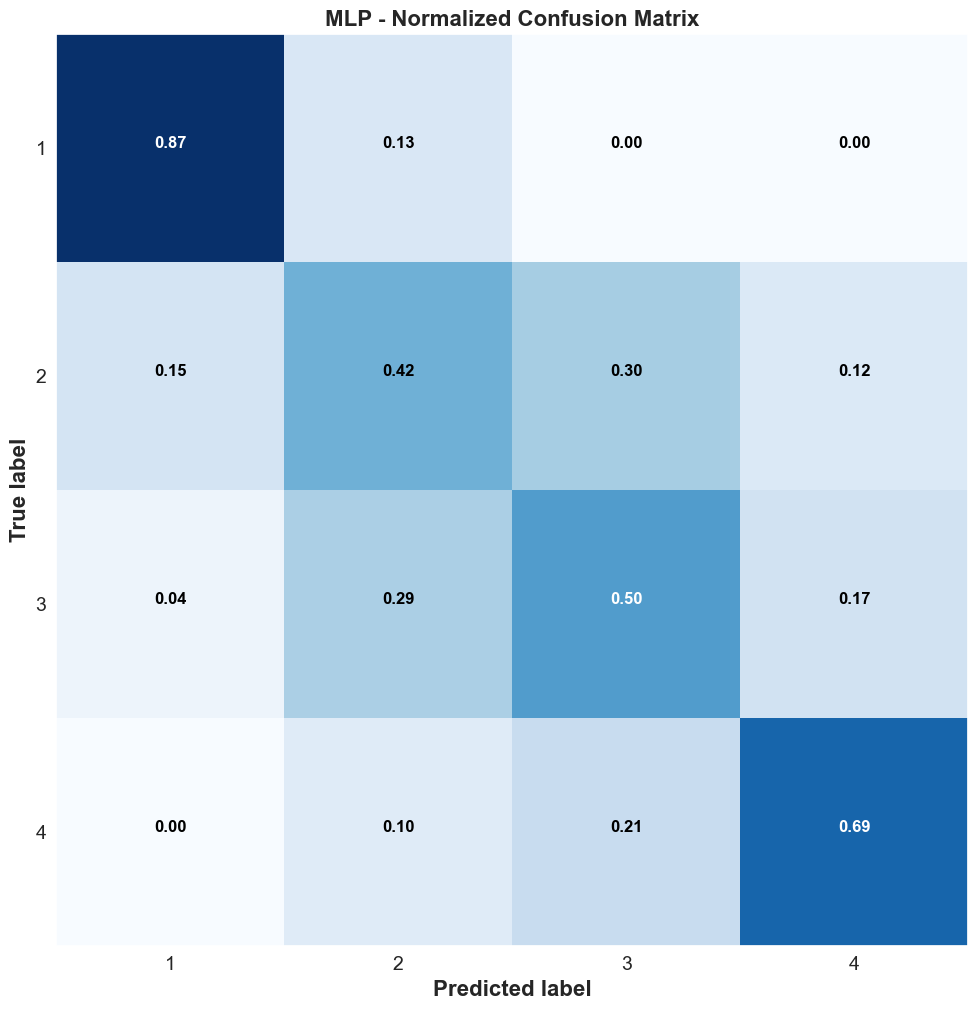

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4'], normalize=True,
                      title='MLP - Normalized Confusion Matrix')
plt.show()

# **5- CNN**

In [25]:
model_cnn = Sequential()

model_cnn.add(Conv1D(32, kernel_size=3, padding='same', activation='relu', input_shape=(16, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2))

model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation='relu'))

model_cnn.add(Dense(5, activation='softmax'))

model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

model_cnn.build(input_shape=(1, 16))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 32)            128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 32)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 4, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 32)             6176      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 2, 32)            

In [26]:
X_train = np.expand_dims(X_train, axis=2)
X_test =  np.expand_dims(X_test, axis=2)

In [27]:
h_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
16/16 [==============================] - 1s 26ms/step - loss: 1.5398 - accuracy: 0.2581 - val_loss: 1.5164 - val_accuracy: 0.1935
Epoch 2/20
16/16 [==============================] - 0s 5ms/step - loss: 1.4466 - accuracy: 0.2560 - val_loss: 1.4421 - val_accuracy: 0.4032
Epoch 3/20
16/16 [==============================] - 0s 4ms/step - loss: 1.3794 - accuracy: 0.3548 - val_loss: 1.3673 - val_accuracy: 0.4435
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 1.3115 - accuracy: 0.4113 - val_loss: 1.2785 - val_accuracy: 0.5000
Epoch 5/20
16/16 [==============================] - 0s 5ms/step - loss: 1.2723 - accuracy: 0.4315 - val_loss: 1.1740 - val_accuracy: 0.5565
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 1.1791 - accuracy: 0.4839 - val_loss: 1.1211 - val_accuracy: 0.5565
Epoch 7/20
16/16 [==============================] - 0s 8ms/step - loss: 1.1537 - accuracy: 0.4577 - val_loss: 1.0580 - val_accuracy: 0.5726
Epoch 8/20
16/16 [=

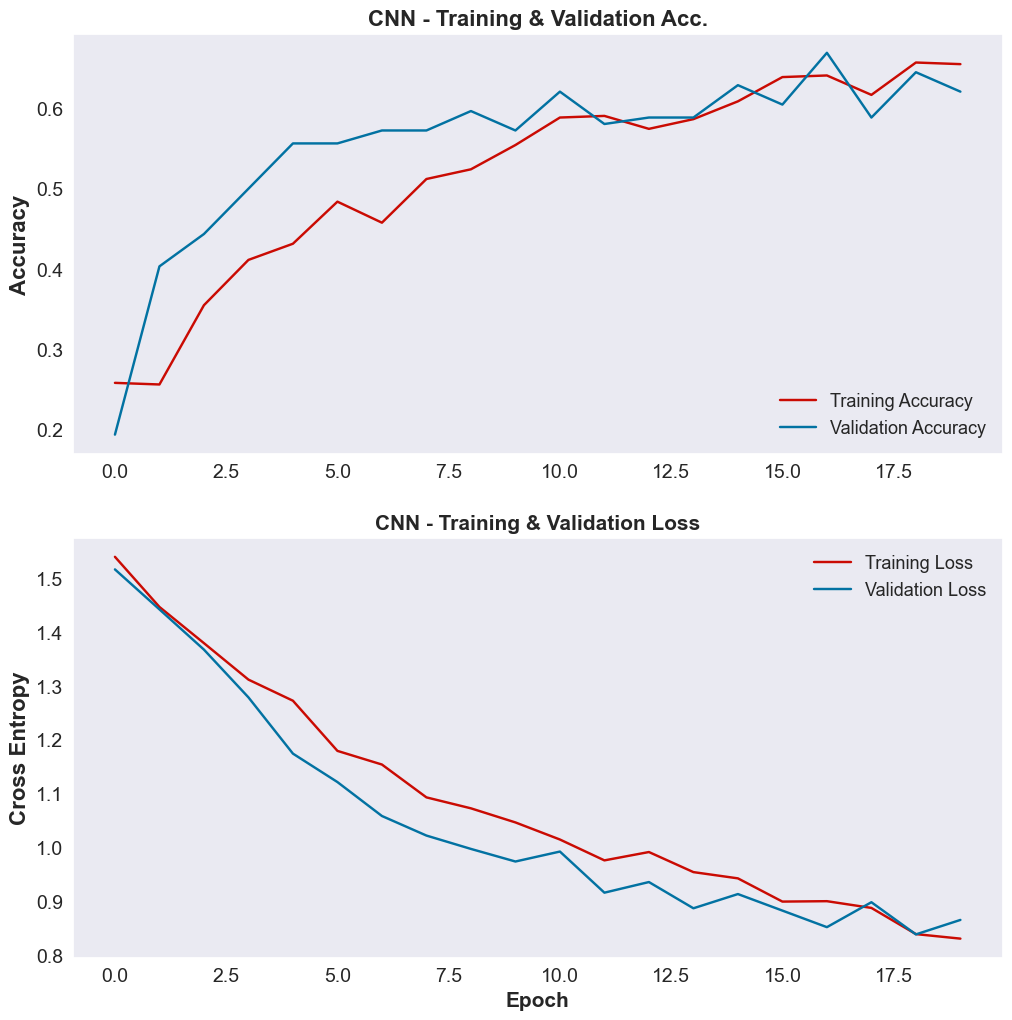

In [28]:
acc = h_cnn.history['accuracy']
val_acc = h_cnn.history['val_accuracy']

loss = h_cnn.history['loss']
val_loss = h_cnn.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('CNN - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('CNN - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

## This too need 'EarlyStopping'

In [29]:
from sklearn.metrics import classification_report

Y_pred = model_cnn.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(y_test, y_pred))

4/4 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           1       0.85      0.87      0.86        38
           2       0.50      0.24      0.33        33
           3       0.43      0.54      0.48        24
           4       0.59      0.79      0.68        29

    accuracy                           0.62       124
   macro avg       0.59      0.61      0.59       124
weighted avg       0.61      0.62      0.60       124



Normalized confusion matrix


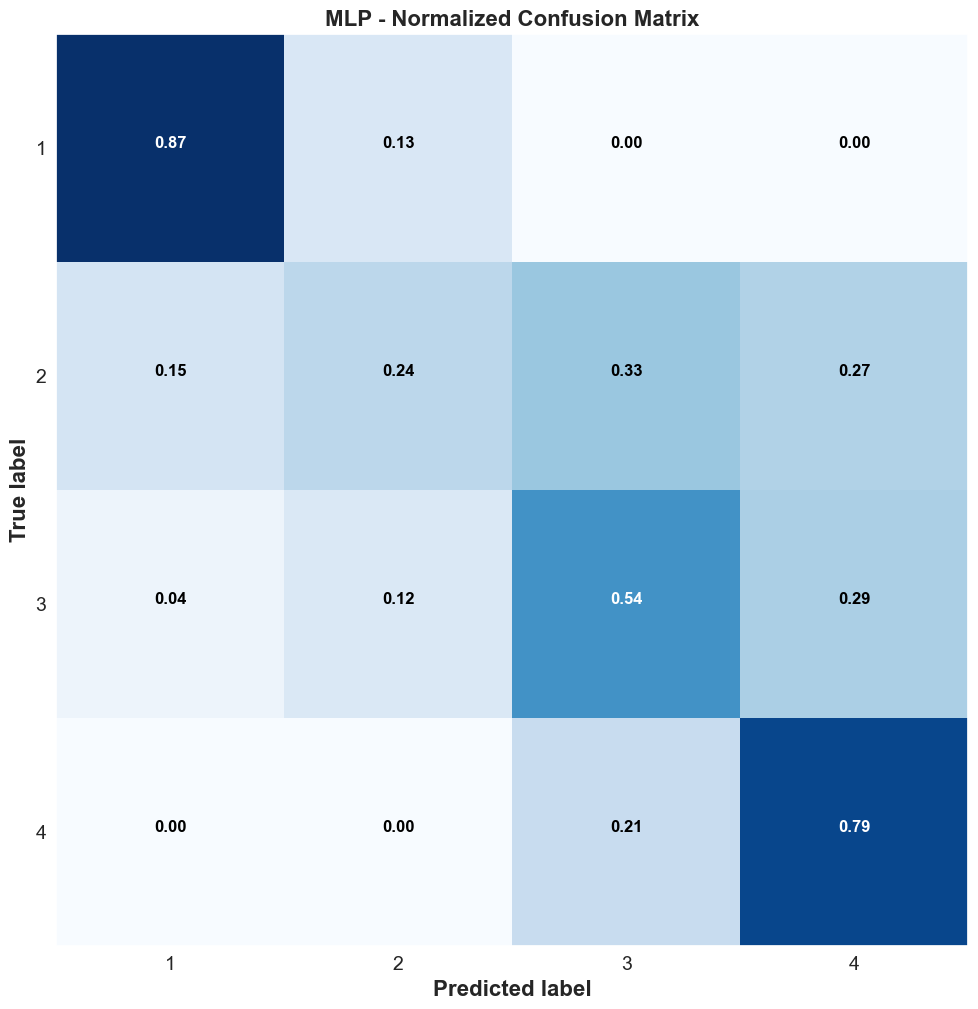

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4'], normalize=True,
                      title='MLP - Normalized Confusion Matrix')
plt.show()